In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from IPython.display import display
import time
from tensorflow.keras import backend as K
import pathlib
from tensorflow.keras.utils import to_categorical

In [2]:
image_path = 'UTKFace'

In [3]:
# age_group = 0-10, 11-20, 21-30, 31-40, 41-50, 51-60, 61+
g1, image1 = [], []
g2, image2 = [], []
g3, image3 = [], []
g4, image4 = [], []
g5, image5 = [], []
g6, image6 = [], []
g7, image7 = [], []

def get_agegroup(image_path):
    for image in os.listdir(image_path):
        age = image.split('_')[0]
        if 0 <= int(age) <= 10 and len(g1) < 2000:
            g1.append(0)
            image1.append(str(image_path)+'/'+image)
        elif 11 <= int(age) <= 20 and len(g2) < 2000:
            g2.append(1)
            image2.append(str(image_path)+'/'+image)
        elif 21 <= int(age) <= 30 and len(g3) < 2000:
            g3.append(2)
            image3.append(str(image_path)+'/'+image)
        elif 31 <= int(age) <= 40 and len(g4) < 2000:
            g4.append(3)
            image4.append(str(image_path)+'/'+image)
        elif 41 <= int(age) <= 50 and len(g5) < 2000:
            g5.append(4)
            image5.append(str(image_path)+'/'+image)
        elif 51 <= int(age) <= 60 and len(g6) < 2000:
            g6.append(5)
            image6.append(str(image_path)+'/'+image)
        elif 61 <= int(age) <= 90 and len(g7) < 2000:
            g7.append(6)
            image7.append(str(image_path)+'/'+image)

In [4]:
get_agegroup(image_path)

In [5]:
print(len(g1), len(g2), len(g3), len(g4), len(g5), len(g6), len(g7))

2000 1659 2000 2000 2000 2000 2000


In [6]:
group = g1+g2+g3+g4+g5+g6+g7
image = image1+image2+image3+image4+image5+image6+image7

print(len(group), len(image))

13659 13659


In [7]:
latent_dim = 50

In [8]:
# scaling the labels to [-1, 1] as proposed in the paper

group_cat = to_categorical(np.array(group))
group_cat = (group_cat *2) - 1
group_cat

array([[ 1., -1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1.,  1.],
       [-1., -1., -1., ..., -1., -1.,  1.],
       [-1., -1., -1., ..., -1., -1.,  1.]], dtype=float32)

In [9]:
# creating a tf dataset.
dataset = tf.data.Dataset.from_tensor_slices((image, group_cat))

In [10]:
for image, label in dataset.take(1):
    print(image, label)

tf.Tensor(b'UTKFace/10_0_0_20161220222308131.jpg.chip.jpg', shape=(), dtype=string) tf.Tensor([ 1. -1. -1. -1. -1. -1. -1.], shape=(7,), dtype=float32)


In [11]:
# image preprocessing
def load_func(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, (128, 128))
    img = (img - 127.5) / 127.5
    img = tf.cast(tf.reshape(img, (128, 128, 3)), dtype=tf.float32)
    return img, label

In [12]:
train_ds = dataset.map(load_func, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\SHOCKER\anaconda\envs\tf_gpu\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


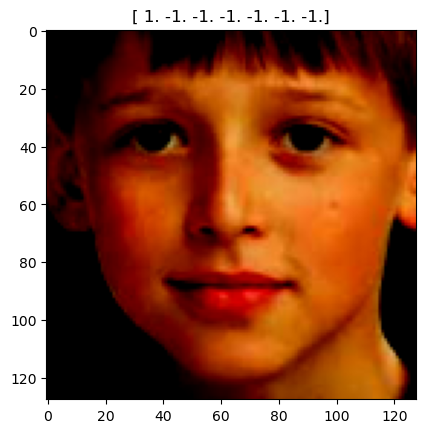

In [14]:
for image, label in train_ds.take(1):
    plt.imshow(image)
    plt.title(label.numpy())

In [15]:
batch_size = 100

In [16]:
train_ds = train_ds.shuffle(2000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

The paper ReLU activation function for each convolution block  in the encoder and generator and no batch normalization. And a tanh activation function for both the encoder and generator. 

In [17]:
def build_encoder():

    """
    Encoder Network
    """
    
    input_layer = keras.Input(shape = (128, 128, 3))

    ## 1st Convolutional Block
    enc = layers.Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same')(input_layer)
    #enc = layers.BatchNormalization()(enc)
    enc = layers.ReLU(alpha=0.2)(enc)
    
    ## 2nd Convolutional Block
    enc = layers.Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = 'same')(enc)
    #enc = layers.BatchNormalization()(enc)
    enc = layers.ReLU(alpha = 0.2)(enc)
    
    ## 3rd Convolutional Block
    enc = layers.Conv2D(filters = 256, kernel_size = 5, strides = 2, padding = 'same')(enc)
    #enc = layers.BatchNormalization()(enc)
    enc = layers.ReLU()(enc)
    
    ## 4th Convolutional Block
    enc = layers.Conv2D(filters = 512, kernel_size = 5, strides = 2, padding = 'same')(enc)
    #enc = layers.BatchNormalization()(enc)
    enc = layers.ReLU()(enc)
    
    
    ## Flatten layer
    enc = layers.Flatten()(enc)
    
    ## 1st Fully Connected Layer
    enc = layers.Dense(4096)(enc)
    #enc = layers.BatchNormalization()(enc)
    enc = layers.ReLU()(enc)
    
    ## 2nd Fully Connected Layer
    enc = layers.Dense(latent_dim, activation='tanh')(enc)
    
    
    ## Create a model
    model = keras.Model(inputs = input_layer, outputs = enc)
    return model


In [18]:
def build_generator(num_classes=7):

    '''
    Generator Network
    '''
    latent_dims = latent_dim
    input_z_noise = keras.Input(shape = (latent_dims, ))
    input_label = keras.Input(shape = (num_classes, ))
    
    init = keras.initializers.RandomNormal(stddev=0.02)
    #li = layers.Embedding(num_classes, 50)(input_label)
    #li = layers.Dense(12*12*1)(li)
    #li = layers.Reshape((12, 12, 1))(li)
    merge = layers.Concatenate()([input_z_noise, input_label])
    
    nodes = 8*8*1024
    x = layers.Dense(nodes)(merge)
    #x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((8, 8, 1024))(x)
    x = layers.Dropout(0.2)(x)
    
    # 1st Deconvolution Block
    x = layers.Conv2DTranspose(filters = 512, kernel_size = 5, padding = 'same', strides=2, kernel_initializer=init)(x)
    #x = layers.BatchNormalization(momentum = 0.8)(x)
    x = layers.ReLU()(x)
    
    # 2nd Deconvolution Block
    x = layers.Conv2DTranspose(filters = 256, kernel_size = 5, padding = 'same', strides=2, kernel_initializer=init)(x)
    #x = layers.BatchNormalization(momentum = 0.8)(x)
    x = layers.ReLU()(x)
    #x = layers.Dropout(0.3)(x)
    
    # 3rd Deconvolution Block
    x = layers.Conv2DTranspose(filters = 128, kernel_size = 5, padding = 'same', strides=2, kernel_initializer=init)(x)
    #x = layers.BatchNormalization(momentum = 0.8)(x)
    x = layers.ReLU()(x)
    
    # 4th Deconvolution Block
    x = layers.Conv2DTranspose(filters = 64, kernel_size = 5, padding = 'same', strides=2, kernel_initializer=init)(x)
    #x = layers.BatchNormalization(momentum = 0.8)(x)
    x = layers.ReLU()(x)
    

    
    dec = layers.Conv2DTranspose(filters = 3, kernel_size = 5, padding = 'same', strides=1, activation='tanh', kernel_initializer=init)(x)
    
    model = keras.Model(inputs = [input_z_noise, input_label], outputs = dec)
    return model


In [19]:
def expand_label_input(x):
    x = K.expand_dims(x, axis = 1)
    x = K.expand_dims(x, axis = 1)
    x = K.tile(x, [1, 64, 64, 1])
    return x


In [20]:
def build_discriminator(num_classes=7):

    """
    Discriminator Network
    """
    
    input_shape = (128, 128, 3)
    label_shape = (num_classes, )
    image_input = keras.Input(shape = input_shape)
    label_input = keras.Input(shape = label_shape)
    
    init = keras.initializers.RandomNormal(stddev=0.02)
    #const = ClipConstraint(0.01)

    #li = layers.Embedding(num_classes, 50)(label_input)
    #li = layers.Dense(48*48*1, activation='relu')(li)
    #li = layers.Reshape((48, 48, 1))(li)

    
    # 1st Convolution Block
    x = layers.Conv2D(16, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer=init)(image_input)
    x = layers.ReLU()(x) 
    
    li = layers.Lambda(expand_label_input)(label_input)
    x = layers.Concatenate()([x, li])

   # 2nd Convolution Block
    x = layers.Conv2D(32, kernel_size = 5, strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)

    # 3rd Convolution Block
    x = layers.Conv2D(64, kernel_size = 5, strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    # 4th Convolution Block
    x = layers.Conv2D(128, kernel_size = 5, strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)  
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(1024, activation='relu')(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)
    #x = layers.Conv2D(1, kernel_size = 5, strides = 1, activation = 'sigmoid')(x)
    model = keras.Model(inputs = [image_input, label_input], outputs = x)
    return model


In [21]:
discriminator = build_discriminator()
generator = build_generator()
encoder = build_encoder()

C:\Users\SHOCKER\anaconda\envs\tf_gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [22]:
#generator.load_weights('generator.h5')
#encoder.load_weights('encoder.h5')

In [23]:
def l2_norm(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))

In [25]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, encoder):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.encoder = encoder
        
        
    def compile(self, d_optimizer, g_optimizer, loss_fn, loss_fn2):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.loss_fn2 = loss_fn2

    def discriminator_loss(self, real, fake):
        real_loss = self.loss_fn(tf.ones_like(real), real)
        fake_loss = self.loss_fn(tf.zeros_like(fake), fake)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake):
        fake_loss = self.loss_fn(tf.ones_like(fake), fake)
        return fake_loss

    def train_step(self, batch):
        tr_image, tr_label = batch
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            
            enc = self.encoder(tr_image)
            generated_image = self.generator([enc, tr_label], training=True)

            real = self.discriminator([tr_image, tr_label], training=True)
            fake = self.discriminator([generated_image, tr_label], training=True)

            gen_loss = self.generator_loss(fake)
            l2_norm = self.loss_fn2(generated_image, tr_image)
            tv_ = tv_loss(generated_image, batch_size)
            disc_loss = self.discriminator_loss(real, fake)
            
            total_loss = 100 * l2_norm + gen_loss
        gen_grad = gen_tape.gradient(total_loss, self.generator.trainable_variables)
        disc_grad = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(disc_grad, self.discriminator.trainable_variables))
        return {"disc_loss": disc_loss, "g_loss": gen_loss, "l2_loss": l2_norm, "total_loss":total_loss}



In [26]:
cWGAN = GAN(discriminator=discriminator, generator=generator, encoder=encoder)

In [27]:
cWGAN.compile(g_optimizer=keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon=10e-8),
             d_optimizer=keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon=10e-8),
             loss_fn=keras.losses.BinaryCrossentropy(),
             loss_fn2=l2_norm)

In [28]:
epochs = 20
for image, label in train_ds.take(1):
    seed = image[0:4, :, :, :]
    labels = label[0:4, :]

In [29]:
labels

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[ 1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1.]], dtype=float32)>

In [30]:
path = 'GAN_IMAGES'


# callback function to generate images after each epoch.
class Generate(keras.callbacks.Callback):
    def __init__(self):
        super(Generate, self).__init__()
        
    def on_epoch_end(self, epoch, logs=None):
        encoded = encoder(seed)
        prediction = generator([encoded, labels])

        plt.figure(figsize=(4, 4))
        for i in range(4):
            plt.subplot(2, 2, i+1)
            plt.imshow(prediction[i])
            plt.axis('off')
            
        plt.savefig(f'{path}/image at epoch {epoch+1}.png')



In [31]:
cWGAN.fit(train_ds, epochs=epochs, callbacks=[Generate()])

Epoch 1/20
 14/137 [==>...........................] - ETA: 1:39:38 - disc_loss: 1.9338 - g_loss: 1.3681 - l2_loss: 0.4826 - total_loss: 51.3069

KeyboardInterrupt: 

Model training was interrupted due to the heaviness of the model.